<a href="https://colab.research.google.com/github/linhkid/gdg-codelab-25/blob/main/Codelab_Unleashing_Gemini_2_0's_Search_and_Multimodal_Capabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this Codelab! We'll explore how to leverage Gemini 2.0's built-in Google Search tool for real-time information retrieval, combine it with multimodal capabilities, and build practical applications with the Google Gen AI SDK.


# Setup Section

## 1. Install Dependencies and Setup Environment

### Install the Google Gen AI SDK
### !pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [1]:
!pip install -U -q google-genai matplotlib pandas plotly python-dateutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
jupyter-server 1.24.0 requires anyio<4,>=3.1.0, but you have anyio 4.9.0 which is incompatible.


In [2]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown
from google.colab import userdata

print("--- 1. Setting up environment ---")
print("# Required packages installed. Setting up your API key next.")

# Load the API key from Colab secrets
# For security, we use Colab's userdata feature
try:
    # @markdown Make sure you have saved your Google AI API key as a Colab secret named 'GOOGLE_API_KEY'
    os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
    print("✅ API key loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your API key by following these steps:")
    print("1. Go to https://ai.google.dev/ to get your API key")
    print("2. In Colab, go to 'Secrets' in the left sidebar")
    print("3. Add a new secret named 'GOOGLE_API_KEY' with your key as the value")
    print("4. Re-run this cell")


--- 1. Setting up environment ---
# Required packages installed. Setting up your API key next.
✅ API key loaded successfully!


# Gemini Model Initialization
## 2. Initialize Gemini 2.0 Model

In [4]:
from google import genai

# Initialize the client with your API key
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'],
                     http_options={'api_version': 'v1alpha'})


# Available models - uncomment the one you want to use
MODEL = 'gemini-2.0-flash-exp'  # Fast, good for quick searches and responses
# MODEL = 'gemini-2.0-pro'  # More capable but slower

print(f"✅ Using model: {MODEL}")
print("# Note: Different models have different capabilities and pricing.")
print("# The 'flash' model is faster while 'pro' is more capable.")

✅ Using model: gemini-2.0-flash-exp
# Note: Different models have different capabilities and pricing.
# The 'flash' model is faster while 'pro' is more capable.


# Helper Functions
## 3. Define Helper Functions for Response Display

In [5]:
def show_parts(response):
    """Display various parts of a Gemini response including text, code, and search results."""
    parts = response.candidates[0].content.parts

    if parts is None:
        finish_reason = response.candidates[0].finish_reason
        print(f'Finish reason: {finish_reason}')
        return

    for part in response.candidates[0].content.parts:
        if part.text:
            display(Markdown(part.text))
        elif hasattr(part, 'executable_code') and part.executable_code:
            display(Markdown(f'```python\n{part.executable_code.code}\n```'))
        else:
            print("Other part type:")
            print(json.dumps(part.model_dump(exclude_none=True), indent=2))

    # Display search results if any
    grounding_metadata = response.candidates[0].grounding_metadata
    if grounding_metadata and grounding_metadata.search_entry_point:
        print("\n📊 Search Results Used:")
        display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [6]:
def visualize_search_usage(responses):
    """Create a visualization of how many searches were used in responses."""
    search_counts = []

    # Process multiple responses to count search usage
    for i, resp in enumerate(responses):
        count = 0
        if hasattr(resp.candidates[0], 'grounding_metadata') and resp.candidates[0].grounding_metadata:
            meta = resp.candidates[0].grounding_metadata
            if hasattr(meta, 'search_entry_point') and meta.search_entry_point:
                # Count the number of search queries
                count = len(meta.search_entry_point.references) if hasattr(meta.search_entry_point, 'references') else 1
        search_counts.append(count)

    # Create a simple bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(search_counts)), search_counts, color='skyblue')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Searches Used')
    plt.title('Search Utilization per Query')
    plt.xticks(range(len(search_counts)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [7]:
print("✅ Helper functions defined for displaying responses and visualizing search usage")
print("# These functions will help us examine how Gemini uses search and processes information.")

✅ Helper functions defined for displaying responses and visualizing search usage
# These functions will help us examine how Gemini uses search and processes information.


# Basic Search Example

## 4. Comparing Responses With and Without Search



In [8]:
print("\n--- 4. Basic Search Comparison Demo ---")
print("# Let's compare how Gemini responds with and without search capabilities")

# Chat without search
regular_chat = client.chats.create(model=MODEL)

print("\n📝 Query without search: 'What are the latest developments in quantum computing?'")
regular_response = regular_chat.send_message('What are the latest developments in quantum computing?')
print("\n🤖 Response WITHOUT search tool:")
show_parts(regular_response)

# Wait a moment before next query
time.sleep(2)

# Chat with search enabled
search_tool = {'google_search': {}}
search_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

print("\n📝 Same query WITH search: 'What are the latest developments in quantum computing?'")
search_response = search_chat.send_message('What are the latest developments in quantum computing?')
print("\n🤖 Response WITH search tool:")
show_parts(search_response)

print("\n# Notice the differences in specificity, recency, and detail between the two responses.")
print("# The search-enabled response can cite recent developments and specific breakthroughs.")


--- 4. Basic Search Comparison Demo ---
# Let's compare how Gemini responds with and without search capabilities

📝 Query without search: 'What are the latest developments in quantum computing?'

🤖 Response WITHOUT search tool:


Quantum computing is a rapidly evolving field, and there have been numerous exciting developments recently. Here's a breakdown of some of the latest happenings, grouped by area:

**1. Hardware Advancements (Qubit Development):**

*   **Increased Qubit Count and Connectivity:**  Companies like IBM, Google, and Quantinuum are consistently increasing the number of qubits in their processors.  While the raw number is important,  *connectivity* (how easily qubits can interact) and *coherence* (how long qubits maintain their quantum state) are equally crucial. The trend is towards denser, more connected architectures.
*   **Improved Qubit Stability (Coherence Time):**  Researchers are making progress in extending the coherence time of qubits, allowing for more complex computations.  Techniques like improved shielding from environmental noise and better control mechanisms are being employed.
*   **Diverse Qubit Technologies:**  While superconducting qubits are currently the most prevalent, there's intense research into other qubit technologies:
    *   **Trapped Ions:**  Quantinuum's trapped ion systems continue to show high fidelity and long coherence times.
    *   **Neutral Atoms:**  Companies like ColdQuanta are making strides with neutral atom qubits, which offer scalability and connectivity advantages.
    *   **Silicon Qubits:**  These are attractive due to their compatibility with existing semiconductor manufacturing, potentially leading to more cost-effective and scalable quantum computers.
    *   **Photonic Qubits:**  These use photons (light particles) to encode quantum information. They offer advantages in terms of coherence and communication, but building large-scale systems remains a challenge.
    *   **Topological Qubits:** Microsoft continues to pursue topological qubits, which are theoretically more resistant to noise and errors. While progress has been slower than anticipated, the potential rewards are significant.

**2. Software and Algorithm Development:**

*   **Quantum Error Correction (QEC):**  QEC is crucial for building fault-tolerant quantum computers.  Significant research is focused on developing more efficient and practical QEC codes.  Progress includes both theoretical breakthroughs and experimental demonstrations of QEC techniques.
*   **Quantum Algorithm Development:**  Researchers are continuously developing new quantum algorithms and improving existing ones to solve specific problems.  Areas of focus include:
    *   **Quantum Machine Learning:** Developing algorithms that leverage quantum mechanics to enhance machine learning models.
    *   **Quantum Chemistry:**  Simulating molecules and chemical reactions with greater accuracy than classical computers.  This has applications in drug discovery and materials science.
    *   **Optimization:**  Solving complex optimization problems that are intractable for classical computers.
    *   **Cryptography:**  Developing quantum-resistant cryptographic algorithms to protect data from future quantum attacks.
*   **Quantum Programming Languages and Tools:**  The development of more user-friendly quantum programming languages and software tools is accelerating. Examples include:
    *   **Qiskit (IBM):** An open-source software development kit for quantum computing.
    *   **Cirq (Google):**  A Python library for writing, manipulating, and optimizing quantum circuits.
    *   **PennyLane (Xanadu):**  A cross-platform Python library for quantum machine learning, differentiable programming, and quantum chemistry.
    *   **Braket (Amazon):**  A cloud-based quantum computing service.

**3. Industry and Applications:**

*   **Increased Industry Investment:**  Significant private and public investment is flowing into quantum computing research and development.
*   **Cloud-Based Quantum Computing Platforms:**  Cloud platforms like Amazon Braket, Azure Quantum, and IBM Quantum Experience provide access to quantum computers for researchers and developers.
*   **Early Applications and Use Cases:**  While fully fault-tolerant quantum computers are still years away, researchers are exploring early applications of noisy intermediate-scale quantum (NISQ) computers. These include:
    *   **Materials Science:**  Simulating the properties of new materials.
    *   **Drug Discovery:**  Identifying potential drug candidates.
    *   **Finance:**  Developing more accurate financial models.
    *   **Logistics and Supply Chain Optimization:**  Improving the efficiency of supply chains.

**4. Key Recent Events and Announcements:**

*   **IBM's Osprey and Condor Processors:** IBM has released increasingly powerful quantum processors, including the Osprey (433 qubits) and the Condor (1121 qubits). They continue to release roadmaps for further scaling.
*   **Google's Quantum Supremacy Claim:** While debated, Google's claim of achieving "quantum supremacy" (performing a calculation that is practically impossible for classical computers) has spurred further research and development.
*   **Continued Investment and Funding:** Governments and private companies are announcing new initiatives and funding rounds to support quantum computing research and development.
*   **Expansion of Quantum Computing Ecosystems:**  More universities and research institutions are establishing quantum computing programs, contributing to the growth of the talent pool.

**Challenges and Future Outlook:**

Despite the impressive progress, significant challenges remain:

*   **Scalability:** Building quantum computers with a large number of qubits is a major hurdle.
*   **Coherence:** Maintaining the quantum state of qubits for long enough to perform complex calculations is crucial.
*   **Error Correction:**  Developing effective quantum error correction techniques is essential for building fault-tolerant quantum computers.
*   **Software Development:**  Creating user-friendly quantum programming languages and tools is vital for wider adoption.
*   **Talent Gap:**  There is a shortage of skilled quantum computing researchers and engineers.

The future of quantum computing is bright, but it will take continued research and development to overcome these challenges and realize the full potential of this transformative technology.  Keep an eye on announcements from the major players (IBM, Google, Quantinuum, Microsoft, Amazon, etc.) and follow leading quantum computing research journals and conferences for the latest updates.



📝 Same query WITH search: 'What are the latest developments in quantum computing?'

🤖 Response WITH search tool:


Here's a summary of the recent developments in quantum computing:

**General Trends:**

*   **Expanding Beyond Computing:** While quantum computing gets a lot of attention, there's increasing focus on quantum sensing and quantum communication for more immediate applications.
*   **From Experiments to Uses:** Quantum technologies are moving from experimental demonstrations to niche commercial products, particularly in areas like drug discovery, materials science, secure communications, and logistics.
*   **Quantum Foundries:** Progress is expected in facilities designed for scalable production of qubits, which will reduce costs and standardize components.
*   **Quantum Error Correction:** Significant progress is being made in quantum error correction, crucial for developing more stable quantum computers.
*   **Hybrid Systems:** Hybrid quantum-classical systems are gaining traction to smooth the transition to full-scale quantum computing.
*   **Quantum Cloud Services:** More companies are offering quantum cloud platforms, making the technology more accessible.
*   **Logical Qubits:** Developers are shifting focus from physical qubits to logical qubits, which are protected from errors.

**Hardware Advancements:**

*   **Google's Willow Chip:** Google launched the Willow chip in 2024, designed to improve qubit coherence and reduce error rates. Willow has 105 qubits and is claimed to be able to perform a benchmark computation in under five minutes, a task that would take the world's second-fastest supercomputer about 10 septillion years.
*   **IBM's Quantum Roadmap:** IBM aims to build a 1,000-qubit quantum computer by 2025. They demonstrated two quantum processing units working together.
*   **IBM's Condor Processor:** IBM's Condor processor has 1,121 superconducting qubits.
*   **Scalability:** Transferring quantum bits between microchips is improving, which is crucial for integrating multiple quantum systems and enhancing the scalability of quantum networks.

**Software and Algorithms:**

*   **Quantum Simulators:** New quantum computing simulators are being launched to make quantum learning more accessible.
*   **Quantum Algorithms:** New algorithms are being developed to take advantage of quantum computing's capabilities, with potential applications in cryptography, materials science, and machine learning.
*   **Shor's Algorithm:** Shor's algorithm for factoring large numbers continues to be important, and a new quantum algorithm has been introduced that may surpass it in efficiency.

**Quantum Networks and Communication:**

*   **Quantum Network Expansion:** Initiatives are underway to accelerate quantum software development and connect global innovators in the quantum space.
*   **Secure Communication:** Secure communication through metropolitan-scale entangled quantum networks is predicted.

**Error Correction:**

*   **Reducing Error Rates:** Researchers are making progress in reducing computational error rates by increasing the number of qubits used for quantum error correction.
*   **Improved Techniques:** Advancements are being made in error correction techniques, essential for stabilizing qubits.

**Other Developments:**

*   **Quantum Education Tools:** New tools are being launched to make quantum learning accessible to students and educators.
*   **International Year of Quantum Science and Technology:** The United Nations has designated 2025 as the International Year of Quantum Science and Technology.

Overall, the field of quantum computing is experiencing rapid growth, with advancements in hardware, software, and error correction techniques. While fully functional quantum computers are still under development, the progress made in recent years suggests that they may become a reality in the not-too-distant future.



📊 Search Results Used:



# Notice the differences in specificity, recency, and detail between the two responses.
# The search-enabled response can cite recent developments and specific breakthroughs.


# Follow-up Questions Example
## 5. Asking Follow-up Questions in a Search Context


--- 5. Follow-up Questions with Search ---
# Gemini can maintain context while using search for follow-up questions

📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'


Based on currently available information, here are three of the top electric vehicles expected to have the longest range in 2025:

1.  **Lucid Air:** The Lucid Air Grand Touring is expected to have the highest range, potentially reaching up to 512 miles.
2.  **Chevrolet Silverado EV:** This pickup truck may achieve up to 460 miles of range.
3.  **Rivian R1S:** This SUV is expected to reach a range of approximately 410 miles.

It's important to remember that these are EPA estimates, and real-world range can vary depending on driving conditions, weather, and other factors.



📊 Search Results Used:



📝 Follow-up Query: 'How much do they cost?'


Here's an overview of the estimated pricing for the 2025 models of the electric vehicles you asked about:

1.  **Lucid Air:** The Lucid Air has several trims, with varying prices. The base Pure model starts around \$71,400, while the Grand Touring trim can reach \$110,900.

2.  **Chevrolet Silverado EV:** The 2025 Chevrolet Silverado EV has a starting price of around \$58,995. However, the RST trim with extended range can cost around \$97,895.

3.  **Rivian R1S:** The base Dual-Motor model starts at \$77,700, while the Tri-Motor Max Pack configuration begins at \$107,700. A Quad-Motor Max Pack is estimated to cost \$130,000.

Keep in mind that these are starting prices, and the final cost can vary depending on the specific configuration, options, and any applicable incentives or tax credits.



📊 Search Results Used:



📝 Another Follow-up: 'Compare their charging times'


Okay, here's a comparison of the charging times for the Lucid Air, Chevrolet Silverado EV, and Rivian R1S, considering different charging methods:

**Lucid Air**

*   **DC Fast Charging:** With a DC fast charging station, the Lucid Air Pure and Touring models have a maximum charging capacity of 200 kW, meaning it would take approximately 25 minutes to charge the Lucid Air Pure and 26 minutes to charge the Lucid Air Touring from 10 to 80 percent. The Lucid Air Grand Touring and Dream Editions have a maximum charging capacity of 300 kW, meaning it would take around 22 minutes to charge the Lucid Air Grand Touring and 23 minutes to charge the Lucid Air Dream from 10 to 80 percent.
*   **Level 2 Charging (22 kW):** Using a standard AC charging station, all models of the Lucid Air have a maximum charging capacity of 22 kilowatts (kW), meaning it would take around 4 hours and 26 minutes to charge the Lucid Air Pure, 4 hours and 38 minutes to charge the Lucid Air Touring, 5 hours and 39 minutes to charge the Lucid Air Grand Touring, and 5 hours and 57 minutes to charge the Lucid Air Dream Editions P and R from 0 to 100 percent.
*   **Level 2 Charging (7kW):** Charging the Lucid Motors Lucid Air Pure takes approximately 11 hours and 54 minutes to charge from zero to full using a typical 7kW home charging point.
*   **Home Charging:** With the Lucid Connected Home Charging Station, you can get up to 80 miles of range per hour of charge.
*   **Lucid's Wunderbox:** The Lucid Air's built-in Wunderbox is compatible with almost all public charging stations. With 900V+ architecture, it's able to fill up to 400 km of charge in about 15 minutes.

**Chevrolet Silverado EV**

*   **DC Fast Charging:** The Silverado EV supports DC fast charging up to 350 kW, allowing drivers to replenish 100 miles of range in just 10 minutes at public charging stations. A charging session from 10 to 80% SOC took over 40.5 minutes.
*   **Level 2 Charging:** Expect the charging time to range from eight to 10 hours for a full charge.
*   **Level 1 Charging:** It might extend the charging time to 24 to 48 hours.

**Rivian R1S**

*   **DC Fast Charging:** The vehicle is equipped with a DC fast-charging capacity that supports speeds of over 200 kW, delivering up to 140 miles of range in just 20 minutes. Rivian claims in the not-too-distant future, it will support DC speeds of 300 kW.
*   **Level 2 Charging:** With an 11.5 kW capability for overnight charging that can deliver up to 16 miles of charge each hour from a 240V outlet. Using a 48-amp charger, Rivian vehicles will add about 25 miles of range per hour and fully recharge in about 12 hours.
*   **Rivian Wall Charger:** Can charge as much as 25 miles per hour.



📊 Search Results Used:



📊 Search Usage Visualization:


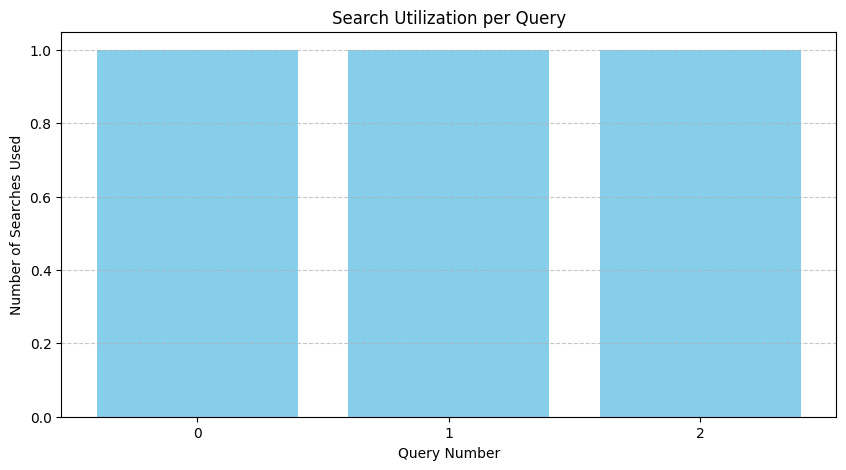


# Notice how Gemini maintains context about which vehicles we're discussing
# while retrieving fresh information for each question.


In [9]:
print("\n--- 5. Follow-up Questions with Search ---")
print("# Gemini can maintain context while using search for follow-up questions")

follow_up_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# List to store responses for visualization
follow_up_responses = []

print("\n📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'")
response1 = follow_up_chat.send_message('What are the top 3 electric vehicles with the longest range?')
show_parts(response1)
follow_up_responses.append(response1)

time.sleep(2)

print("\n📝 Follow-up Query: 'How much do they cost?'")
response2 = follow_up_chat.send_message('How much do they cost?')
show_parts(response2)
follow_up_responses.append(response2)

time.sleep(2)

print("\n📝 Another Follow-up: 'Compare their charging times'")
response3 = follow_up_chat.send_message('Compare their charging times')
show_parts(response3)
follow_up_responses.append(response3)

# Visualize search usage across the conversation
print("\n📊 Search Usage Visualization:")
visualize_search_usage(follow_up_responses)

print("\n# Notice how Gemini maintains context about which vehicles we're discussing")
print("# while retrieving fresh information for each question.")

# Combining Search with Data Visualization
## 6. Creating Data Visualizations with Search-Sourced Data

In [14]:
print("\n--- 6. Data Visualization with Search-Sourced Data ---")
print("# Gemini can use search to find data and generate code to visualize it")

# Create a new chat with search enabled for data visualization
viz_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# Explicitly ask for Python code to visualize the data
viz_prompt = """
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
"""

print(f"\n📝 Query: '{viz_prompt}'")
viz_response = viz_chat.send_message(viz_prompt)
show_parts(viz_response)

print("\n# The code above can be copied into a code cell and executed to create the visualization.")
print("# Gemini has sourced recent economic data and created visualization code.")


--- 6. Data Visualization with Search-Sourced Data ---
# Gemini can use search to find data and generate code to visualize it

📝 Query: '
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
'


Okay, I will find the GDP growth rates for the world's top 5 economies for the most recent year, create a Pandas DataFrame with the data, generate a bar chart comparing the growth rates using Matplotlib, and format the chart for clear visualization.



Based on the search results, here's the GDP growth data and the Python code to generate the visualization:

**Top 5 Economies (Nominal GDP) and their GDP Growth Rates (Most Recent Available Data - 2024)**

Based on multiple sources, the top 5 economies are:

1.  **United States:**  GDP Growth for 2024: 2.5% (Source: Trading Economics, Dec/24)
2.  **China:** GDP Growth for 2024: 5.4% (Source: Trading Economics, Dec/24)
3.  **Germany:** GDP Growth for 2024: -0.2% (Source: Trading Economics, Dec/24)
4.  **Japan:** GDP Growth for 2024: 1.2% (Source: Trading Economics, Dec/24)
5.  **India:** GDP Growth for 2024: 6.2% (Source: Trading Economics, Dec/24)

Here's the Python code to create the DataFrame and the bar chart:



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.5, 5.4, -0.2, 1.2, 6.2]}

# Create Pandas DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by GDP Growth Rate for better visualization
df = df.sort_values(by='GDP Growth Rate', ascending=False)

# Create Bar Chart
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=['green', 'royalblue', 'red', 'darkorange', 'purple'])

# Add labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Show the plot
plt.show()
```



**Explanation:**

1.  **Import Libraries:** Imports `pandas` for creating a DataFrame and `matplotlib.pyplot` for plotting.
2.  **Data:** Defines a dictionary containing the country names and their corresponding GDP growth rates.
3.  **Create DataFrame:** Creates a Pandas DataFrame from the dictionary.
4.  **Sort DataFrame:** Sorts the DataFrame by 'GDP Growth Rate' in descending order to display the highest growth rate first.
5.  **Create Bar Chart:**
    *   Creates a figure and axes using `plt.subplots()`.
    *   Generates a bar chart using `plt.bar()`, specifying the countries as x-axis values and GDP growth rates as y-axis values.  Sets custom colors for each bar.
6.  **Labels and Title:** Adds labels to the x and y axes and sets the title of the chart.  Rotates the x-axis labels for better readability.
7.  **Value Labels:** Iterates through the bars and adds the GDP growth rate value on top of each bar using `plt.text()`.
8.  **Grid Lines:** Adds horizontal grid lines to improve readability.
9.  **Remove Spines:**  Removes the top and right spines to make the chart cleaner.
10. **Layout Adjustment:** Uses `plt.tight_layout()` to adjust the plot layout and prevent labels from overlapping or being cut off.
11. **Show Plot:** Displays the generated bar chart using `plt.show()`.

This code will produce a bar chart that visually compares the GDP growth rates of the top 5 economies, with clear labels, a title, and appropriate color-coding for enhanced clarity. The value labels on top of the bars provide precise growth rate figures.



📊 Search Results Used:



# The code above can be copied into a code cell and executed to create the visualization.
# Gemini has sourced recent economic data and created visualization code.


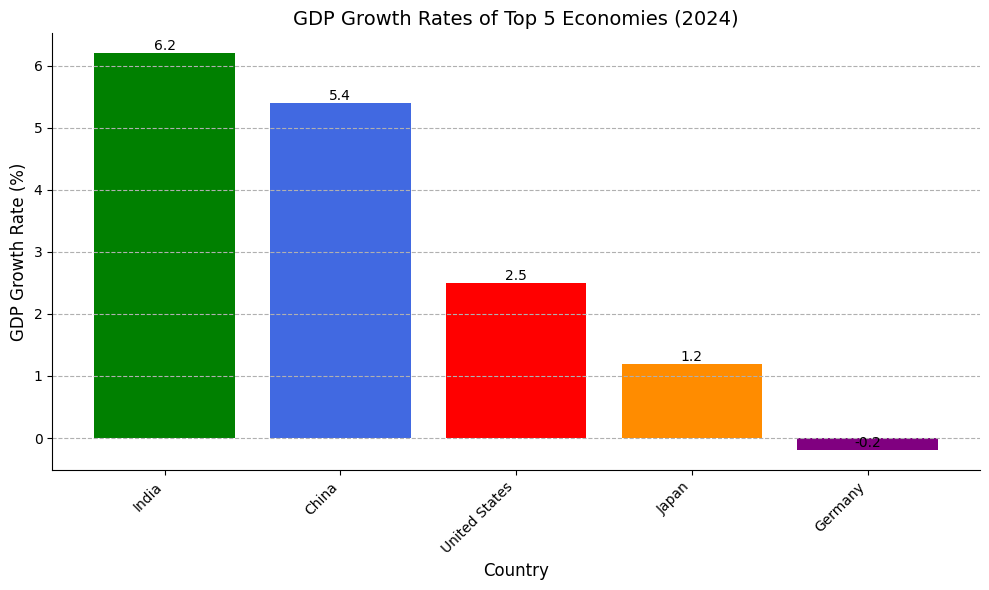

In [15]:
#Visualized the generated code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.5, 5.4, -0.2, 1.2, 6.2]}

# Create Pandas DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by GDP Growth Rate for better visualization
df = df.sort_values(by='GDP Growth Rate', ascending=False)

# Create Bar Chart
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=['green', 'royalblue', 'red', 'darkorange', 'purple'])

# Add labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Show the plot
plt.show()


# Multimodal Search Example
## 7. Combining Search with Multimodal Capabilities


--- 7. Multimodal Search Exploration ---
# Gemini 2.0 can combine search with analysis of uploaded images

In this section, you'll upload an image and Gemini will:
1. Analyze the visual content to identify what's in the image
2. Use Google Search to find accurate, detailed information about the subject
3. Allow you to ask follow-up questions in the same conversation context

This demonstrates how Gemini combines visual understanding with search capabilities.

📸 Let's try this out!
Please upload an image (landmark, artwork, product, etc.)


Saving Dog_Breeds.jpg to Dog_Breeds.jpg
Uploaded image:


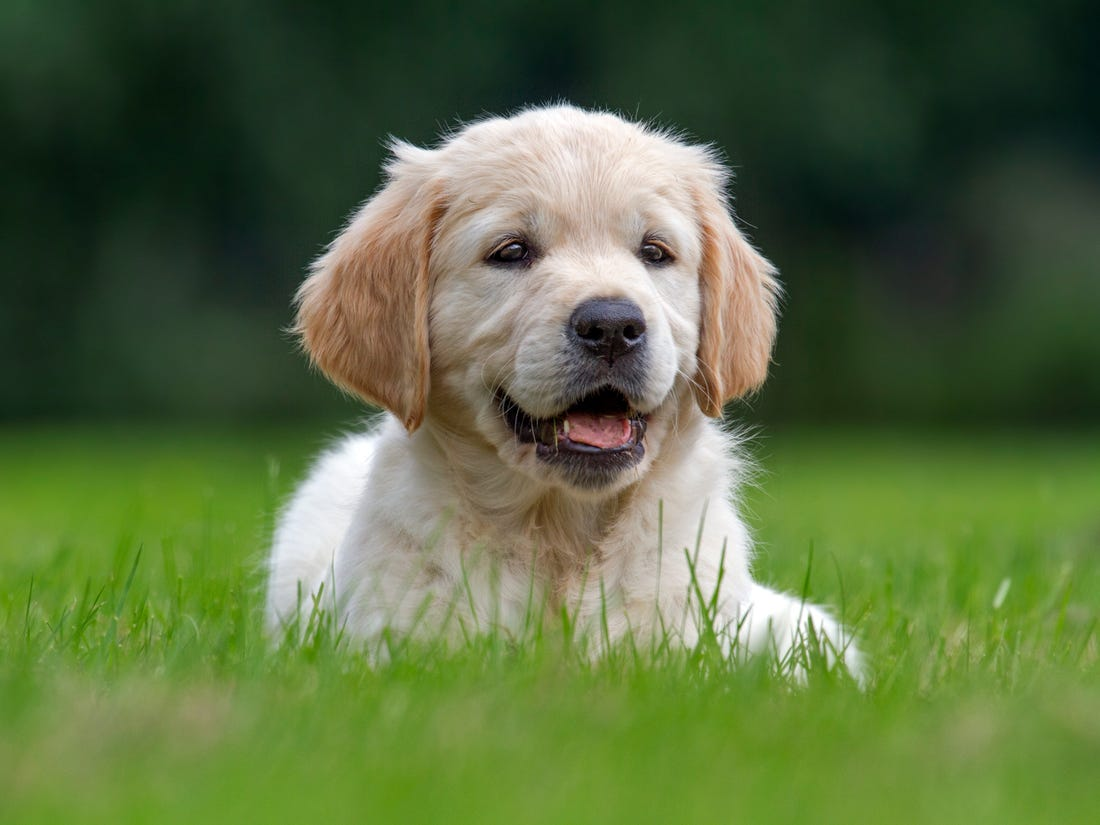


🔍 Analyzing image...


Here's a breakdown of what I can see in the image:

*   **Main Subject:** A portion of an economics or business-related examination.

*   **Description:** The image shows a section of multiple choice economics or business management questions, likely from a test or quiz.




🔍 Searching for detailed information...


While a specific creation date for economics and business examinations is difficult to pinpoint, here's a general overview and interesting facts:

**History and Evolution**

*   **Early Forms:** The concept of assessing knowledge in economics and business-related fields has likely existed for centuries in various forms. Early forms of assessment would have been more informal, perhaps involving apprenticeships or oral examinations.
*   **Formal Examinations:** As universities and business schools developed, so did more standardized forms of testing. Standardized tests became more common in the 19th and 20th centuries.
*   **Evolution of Content:** The content of economics and business exams has evolved to reflect changes in economic theories, business practices, and the global landscape.
*   **Modern Testing:** Modern economics and business exams often include a mix of multiple-choice questions, short-answer questions, essay questions, and case studies. Some exams also incorporate quantitative analysis and data interpretation.

**Interesting Facts**

*   **GMAT:** The Graduate Management Admission Test (GMAT) is specifically designed for graduate business programs and is a proven predictor of a student's ability to succeed in the classroom.
*   **Skills tested:** Modern business school graduates need problem-solving, communication, and strategic thinking skills. The GMAT exam is designed to measure these skills.
*   **Emphasis on Application:** Modern economics and business exams emphasize the application of theoretical knowledge to real-world scenarios.




📊 Search Results Used:



📝 You can now ask follow-up questions about the image!
Example follow-up questions:
- 'How does it compare to similar examples?'
- 'What are common misconceptions about it?'
- 'When was the last major renovation or change?'
Enter a follow-up question (or press Enter to skip): That is a dog image,  can you check it again?

🔍 Searching for answer to: 'That is a dog image,  can you check it again?'


I apologize for the error. You are absolutely correct; the image is indeed of a dog, not an economics exam. I am still learning to properly classify images.

Based on the image, here is the description of the dog.

*   **Main Subject:** Dog
*   **Description:** It's a close-up, head-on shot of a dog. The breed isn't immediately clear, but it has a distinctive coat coloring.


In [17]:
print("\n--- 7. Multimodal Search Exploration ---")
print("# Gemini 2.0 can combine search with analysis of uploaded images")

from IPython.display import display, Image
from google.colab import files
import base64
import io

def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def upload_and_analyze_image():
    """Upload an image and analyze it with Gemini + Search"""
    print("Please upload an image (landmark, artwork, product, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Skipping image analysis.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Display the uploaded image
    print("Uploaded image:")
    display(Image(filename=image_path))

    # Encode the image to base64
    base64_image = encode_image(image_path)

    # Create a new multimodal message with the image
    multimodal_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # First prompt to identify the image
    identification_prompt = f"""
    data:image/jpeg;base64,{base64_image}

    What is shown in this image? Please identify the main subject and provide a brief description.
    """

    print("\n🔍 Analyzing image...")
    identification_response = multimodal_chat.send_message(identification_prompt)
    show_parts(identification_response)

    # Second prompt to get more detailed information with search
    detail_prompt = "Please search for more detailed information about this subject, including when it was created/built, its history, and interesting facts."

    print("\n🔍 Searching for detailed information...")
    detail_response = multimodal_chat.send_message(detail_prompt)
    show_parts(detail_response)

    return multimodal_chat

# Explanation for workshop participants
print("\nIn this section, you'll upload an image and Gemini will:")
print("1. Analyze the visual content to identify what's in the image")
print("2. Use Google Search to find accurate, detailed information about the subject")
print("3. Allow you to ask follow-up questions in the same conversation context")
print("\nThis demonstrates how Gemini combines visual understanding with search capabilities.")

# Run the interactive image upload and analysis
print("\n📸 Let's try this out!")
multimodal_chat = upload_and_analyze_image()

# Provide instructions for follow-up questions
if multimodal_chat:
    print("\n📝 You can now ask follow-up questions about the image!")
    print("Example follow-up questions:")
    print("- 'How does it compare to similar examples?'")
    print("- 'What are common misconceptions about it?'")
    print("- 'When was the last major renovation or change?'")

    # Option to ask a follow-up question
    follow_up = input("Enter a follow-up question (or press Enter to skip): ")
    if follow_up:
        print(f"\n🔍 Searching for answer to: '{follow_up}'")
        follow_up_response = multimodal_chat.send_message(follow_up)
        show_parts(follow_up_response)

# Practical Applications

## 8. Practical Applications of Search-Enabled AI

In [12]:
print("\n--- 8. Practical Applications Workshop ---")
print("# Let's explore practical real-world applications of search-enabled AI")

# Create a chat for practical applications
practical_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

application_scenarios = [
    "Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.",
    "Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.",
    "Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.",
    "Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).",
    "Educational Tool: Create learning materials with current facts, figures, and examples."
]

for i, scenario in enumerate(application_scenarios):
    print(f"\n{i+1}. {scenario}")

# Example of market analysis application
print("\n📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'")
market_response = practical_chat.send_message('Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.')
show_parts(market_response)


--- 8. Practical Applications Workshop ---
# Let's explore practical real-world applications of search-enabled AI

1. Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.

2. Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.

3. Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.

4. Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).

5. Educational Tool: Create learning materials with current facts, figures, and examples.

📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'


Okay, here's an analysis of the current state of the electric vehicle market in Europe, including major players, market share, and growth trends. Because the market is constantly evolving, I will use current data to provide the most up-to-date information.



Here's an analysis of the current state of the electric vehicle market in Europe:

**Overall Market**

*   **Growth:** The European EV market is experiencing growth, although the pace has fluctuated. In early 2025, the market showed a solid start with approximately 50% growth in February compared to the previous year.
*   **Sales Figures:** In 2023, new electric car registrations reached nearly 3.2 million, an increase of almost 20% compared to 2022. Within the European Union, sales amounted to 2.4 million, reflecting similar growth rates.
*   **Projections:** EV sales in Western Europe, including the UK, are expected to rise by 40% in 2025, reaching 2.7 million vehicles. Battery-electric vehicles (BEVs) are projected to account for 22% of the total market share.
*   **Market Share:** Battery electric vehicles (BEVs) made up 15% of the market share in January 2025, an increase from 10.9% in January 2024. In September 2024, plug-in vehicles reached a 26% share of the overall market, with BEVs alone representing 19%.
*   **Vehicle Types:** While passenger cars are the focus of the EV revolution, electric trucks are also gaining traction. In 2023, electric truck sales surpassed electric bus sales for the first time.
*   **Charging Infrastructure:** Europe has been expanding its charging infrastructure, with over 630,000 publicly available EV chargers in 2023.

**Key Players**

*   **Leading Brands:** Tesla has been a leading EV brand in Europe. In 2024, Tesla topped the European EV market for the third year in a row. The Tesla Model Y recorded 28,995 registrations in September 2024, leading the European EV market.
*   **Top Manufacturers:** Other major players include Volkswagen Group, BMW, Mercedes-Benz, Renault, and Stellantis.
*   **Market Share by Group:** Volkswagen Group has maintained a dominant position in the European market with a significant market share.
*   **Chinese Manufacturers:** Chinese manufacturers like BYD are expanding into the European market, offering typically lower prices.

**Trends and Factors**

*   **BEV vs. PHEV:** Battery electric vehicles (BEVs) are generally leading the growth, although there are fluctuations. Sales of plug-in hybrid electric cars grew faster than BEVs in China in early 2024. In Europe, however, the BEV market is taking the "lion's share" of growth.
*   **Government Regulations and Incentives:** Stricter CO2 regulations set for 2025 are influencing manufacturers' strategies. Changes to subsidy policies in countries like Germany have impacted EV sales.
*   **Consumer Preferences:** There's a clear shift in consumer preferences towards EVs, with over half of new car buyers opting for vehicles with at least partial electric capability.
*   **Competition:** Europe faces increasing competition from Chinese automakers, who are introducing more affordable models. The EU is considering additional tariffs on Chinese imports, which could impact market dynamics.
*   **Regional Differences:** EV adoption rates vary across Europe. Norway, Sweden, and the Netherlands remain the largest European markets.

**Challenges and Considerations**

*   **Decelerating Sales:** EV sales in Europe have decelerated in recent months.
*   **Subsidy Changes:** Declines in battery-electric-vehicle (BEV) subsidies have influenced the market.
*   **Affordability:** Burgeoning consumer interest in affordable EVs is a key factor.
*   **Infrastructure:** Ensuring sufficient charging infrastructure remains crucial for sustaining growth.
*   **Market Saturation:** Increasing stock days in some markets point towards market saturation.



📊 Search Results Used:


# Advanced Search Parameters
## 9. Advanced Search Parameters and Techniques

In [13]:
print("\n--- 9. Advanced Search Techniques ---")
print("# Exploring how to get more precise and controlled search results")

# Create a chat for advanced search techniques
advanced_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

advanced_techniques = """
## Advanced Search Techniques

When working with Gemini's search capability, consider these techniques:

1. **Be Specific in Your Queries**
   - Precise queries yield better search results
   - Example: "Latest NVIDIA GPU specs released in 2024" vs. "new graphics cards"

2. **Request Source Attribution**
   - Ask Gemini to cite its sources
   - Example: "Provide information about X with citations to your sources"

3. **Control Search Depth vs. Speed**
   - For quick facts, use simpler queries and flash models
   - For comprehensive research, use more detailed queries and pro models

4. **Iterative Refinement**
   - Start broad, then use follow-up questions to narrow down
   - Example: First ask about "renewable energy trends" then drill down to "solar panel efficiency improvements"

5. **Explicitly Request Search When Needed**
   - If you notice outdated information, explicitly ask for a search
   - Example: "Please search for the most recent data on X"
"""

display(Markdown(advanced_techniques))

# Example of a well-structured query
print("\n📝 Example of Well-Structured Query: 'Search for the latest breakthroughs in mRNA vaccine technology from 2023-2024, focusing on developments beyond COVID applications. Include names of key research institutions and potential timeline for clinical applications.'")
advanced_response = advanced_chat.send_message('Search for the latest breakthroughs in mRNA vaccine technology from 2023-2024, focusing on developments beyond COVID applications. Include names of key research institutions and potential timeline for clinical applications.')
show_parts(advanced_response)



--- 9. Advanced Search Techniques ---
# Exploring how to get more precise and controlled search results



## Advanced Search Techniques

When working with Gemini's search capability, consider these techniques:

1. **Be Specific in Your Queries**
   - Precise queries yield better search results
   - Example: "Latest NVIDIA GPU specs released in 2024" vs. "new graphics cards"

2. **Request Source Attribution**
   - Ask Gemini to cite its sources
   - Example: "Provide information about X with citations to your sources"

3. **Control Search Depth vs. Speed**
   - For quick facts, use simpler queries and flash models
   - For comprehensive research, use more detailed queries and pro models

4. **Iterative Refinement**
   - Start broad, then use follow-up questions to narrow down
   - Example: First ask about "renewable energy trends" then drill down to "solar panel efficiency improvements"

5. **Explicitly Request Search When Needed**
   - If you notice outdated information, explicitly ask for a search
   - Example: "Please search for the most recent data on X"



📝 Example of Well-Structured Query: 'Search for the latest breakthroughs in mRNA vaccine technology from 2023-2024, focusing on developments beyond COVID applications. Include names of key research institutions and potential timeline for clinical applications.'


The rapid development and deployment of mRNA vaccines for COVID-19 has spurred significant advancements in mRNA vaccine technology and expanded its potential applications beyond infectious diseases. Here's a summary of the latest breakthroughs from 2023-2024:

**Key Breakthroughs and Trends:**

*   **Next-generation mRNA vaccines:** Evolution from linear mRNA vaccines to self-amplifying RNA (saRNA) and circular RNA (circRNA) technologies. These next-generation technologies address the limitations of linear mRNA vaccines, such as the need for high doses and short-term immunity.
    *   **saRNA:** Adds a "photocopier gene" to mRNA vaccines, potentially leading to longer-lasting immune responses and reduced side effects. Preclinical data suggests saRNA vaccines can achieve long-lasting immunity from a single, low dose.
    *   **circRNA:** Possesses a closed-loop structure, offering high pharmaceutical and biostability compared to linear mRNA.
*   **Improved T-cell vaccines:** Development of more effective T-cell vaccines and advancements in assays for T cells. Work is underway to develop vaccines that efficiently amplify T-cell immunity.
*   **Advancements in delivery technologies:** Innovations in delivery technologies like lipid nanoparticles (LNPs) enhance the stability and precision of mRNA therapeutics, improving targeting and reducing immunogenicity issues. LNPs are the only drug delivery system that has demonstrated clinical effectiveness and received approval for human use.
*   **Personalized cancer vaccines:** mRNA vaccines are being developed to target neoantigens unique to a patient's tumor, stimulating a robust immune response that specifically targets cancer cells while sparing healthy tissue.
*   **Combination vaccines:** The development of combination vaccines, including those for COVID-19, influenza, and RSV, is ongoing.

**Applications Beyond COVID-19:**

*   **Infectious Diseases:** mRNA vaccines are being explored for a wide range of infectious diseases, including:
    *   Influenza
    *   RSV (Respiratory Syncytial Virus)
    *   HIV
    *   Zika virus
    *   CMV (Cytomegalovirus)
    *   Epstein-Barr virus
    *   Hepatitis B and C
    *   Malaria
*   **Cancer Therapy:** mRNA vaccines are being developed for various types of cancer, including:
    *   Pancreatic cancer
    *   Ovarian cancer
    *   Melanoma
*   **Other Therapeutic Areas:**
    *   Regenerative medicine
    *   Immunotherapy
    *   Genetic disorders
    *   Autoimmune diseases

**Key Research Institutions and Companies:**

*   **Universities:**
    *   Harvard University
    *   University of California System
    *   Harvard Medical School
    *   University of Pennsylvania
    *   University Medical Center Groningen
    *   Imperial College London
*   **Hospitals and Research Centers:**
    *   Memorial Sloan Kettering Cancer Center
    *   National Institutes of Health (NIH)
    *   National Institute of Allergy and Infectious Disease (NIAID)
*   **Companies:**
    *   Moderna
    *   BioNTech (Pfizer)
    *   CureVac
    *   Arcturus Therapeutics
    *   Sanofi
    *   Regeneron Pharmaceuticals

**Timeline for Clinical Applications:**

*   mRNA vaccines against influenza, HIV, tuberculosis, cancer, food, and environmental allergies are already in clinical trials or ready for clinical application.
*   In the 2010s, early-phase clinical trials for personalized cancer vaccines targeting melanoma and other cancers were initiated.
*   Combination vaccines for COVID-19, influenza, and RSV are in the mRNA vaccines pipeline.
*   It takes at least 1 year for a phase I clinical trial to be complete, a few years for phase III clinical trials to be complete, and around 10 years for the whole process of vaccine development to licensure.



📊 Search Results Used:


In [19]:
summary = """
## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
"""

display(Markdown(summary))

print("Thank you for participating in this workshop!")
print("We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.")


## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/


Thank you for participating in this workshop!
We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.
